# Sensitivity Analyses for Avila et al paper...
Thi notebook contains bla .. bla ... bla ...

In [1]:
# Import python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Functions
# ---------

# Isotopic mass balance equations:
def simSr(jr, rr, rsw, jh, rh, n):
    """
    Strontium isotopic mass balance.

    Parameters
    ----------
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSr : float
        Strontium isotopic ratio of seawater.

    """
    rSr = (jr*(rr-rsw) + jh*(rh-rsw)) / n
    return rSr

# Wrapper to run mass balance model
def run_sim(nt, dt, age, jr, rr, rsw, jh, rh, n):
    """
    Solving diff. equations defined in simSr() using the forward Euler method.

    Parameters
    ----------
    nt : int
        number of time steps to run model
    dt : float
        the size of each time step
    age : float
        age in million years
    jr : float
        Global riverine flux of Sr
    rr : float
        Strontium isotopic ratio of global riverine flux.
    rsw : float
        Strontium isotopic ratio of seawater.
    jh : float
        Hydrothermal flux of Sr.
    rh : float
        Strontium isotopic ratio of hydrothermal flux (jh).
    n : float
        Strontium reservoir size of the ocean.

    Returns
    -------
    rSw : float
        Strontium isotopic ratio of seawater.
    grad : float
          gradient of rSw  
        
    """
    rsw0 = (jr[0]*rr[0] + jh[0]*rh[0])/(jr[0]+jh[0])
    rsw[0] = rsw0
    
    for i in range(nt-1):
        rsw[i+1] = rsw[i] + simSr(jr[i], rr[i], rsw[i], jh[i], rh[i], n[i])*dt
    
    grad = np.diff(rsw)/np.diff(age)
    grad = np.append(grad, grad[-1])
   
    return rsw, grad

# Initialize array of values of size N
def initialize(N, val):
    """
    Create a 1D array size N, with values=val
    
    Parameters
    ----------
    N : int
        size of array
    val : float
        initial values
    
    Return
    ------
    array_like
        array size (1 x N) values = val
    """
    return np.ones(N)*val

# Simulate system perturbation
def perturbation(flux, flux0,age, start_age, stop_age, f1, f2):
    """
    Function to simulate a system perturbation, by increasing or decreasing flux linierly from start_age to stop_age
    by factor f.
    
    Paramaters
    ----------
    flux : array_like
        flux or reservoir 
    age : array_like
        age or time grid
    start_age : array like
        onset of perturbation
    stop_age : array like
        end of perturbation
    
    """
    start = np.where(np.round(age)==start_age)[0][0]
    stop = np.where(np.round(age)==stop_age)[0][0]
    
    flux[:start] = np.linspace(flux0, flux0*f1, start)
    flux[start:stop] = np.linspace(flux0*f1, flux0*f2, stop-start)
    flux[stop:] = flux0*f2
    return flux

# Function to run model with a dictionary_like input
def run_model(param):
    # Unpack parameters
    tmin = param['tmin']
    tmax = param['tmax']
    nt = param['nt']
    dt = (tmin - tmax)*1e6 / nt
    age = np.linspace(tmin, tmax, nt)
    
    Jriv = initialize(nt, param['Jriv'])
    Rriv = initialize(nt, param['Rriv'])
    Jh = initialize(nt, param['Jh'])
    Rh = initialize(nt, param['Rh'])
    N = initialize(nt, param['N'])
    
    Rsw = initialize(nt, 1)
    GradSr = initialize(nt, 1)
    
    if param['SimplePerturbation']:
        Jh = perturbation(Jh, param['Jh'], age, param['start'], param['stop'], param['f1'], param['f2'])
    else:
        Jh = param['Jhvec']
   
    Rsw, GradSr = run_sim(nt, dt, age, Jriv, Rriv, Rsw, Jh, Rh, N)
    
    output = {
        'Rsw' : Rsw,
        'GradSr' : GradSr,
        'age' : age,
        'Jriv' : Jriv,
        'Rriv' : Rriv,
        'Jh' : Jh,
        'Rh' : Rh,
        'N' : N,
    }
    return output

In [3]:
param = {
    'tmin' : 487,
    'tmax' : 443,
    'nt' : 100000,
    
    'Jriv' : 3e10,
    'Rriv' : 0.7106,
    
    'Jh' : 8e9,
    'Rh' : 0.7037,
    
    'N' : 1.9e17,
    
    'SimplePerturbation' : True,
    'f1' : 1.6,
    'start' : 460,
    'stop' : 455,
    'f2' : 2.5    
}
base = run_model(param)

# Load sr measurement for comparison
SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
plt.figure(figsize=(10,7))
plt.plot(base['age'], base['Rsw'])
plt.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', alpha=0.4)

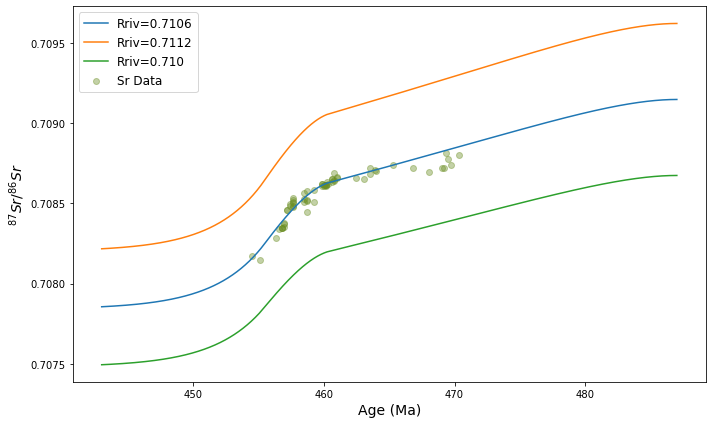

In [52]:
param['Rriv'] = 0.7112 # 
base_riverine = run_model(param)
param['Rriv'] = 0.7100 # 
base_riverine2 = run_model(param)
plt.figure(figsize=(10,6))
plt.plot(base['age'], base['Rsw'], label='Rriv=0.7106')
plt.plot(base_riverine['age'], base_riverine['Rsw'], label='Rriv=0.7112')
plt.plot(base_riverine2['age'], base_riverine2['Rsw'], label='Rriv=0.710')
plt.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', alpha=0.4, label='Sr Data')

plt.legend(fontsize=12)

plt.ylabel(r'$^{87}Sr/^{86}Sr$', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.tight_layout()
plt.savefig('../Figure/SensitivityAnalyses/RiverineSrRatio.pdf')
plt.savefig('../Figure/SensitivityAnalyses/RiverineSrRatio.png')

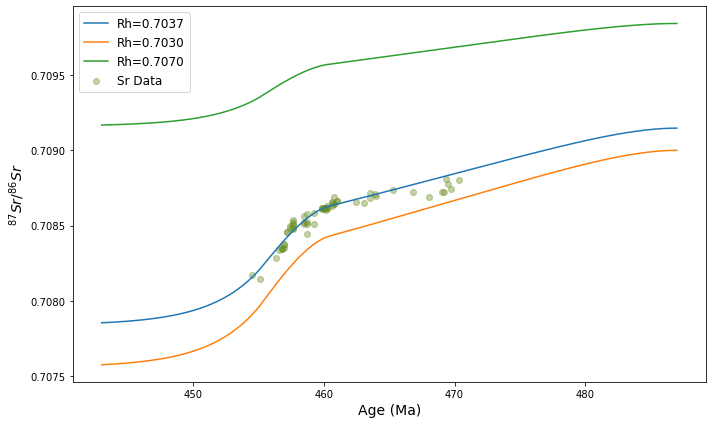

In [53]:
param['Rriv'] = 0.7106
baseHT = run_model(param)

param['Rh'] = 0.7030
baseHT_low = run_model(param)

param['Rh'] = 0.7070
baseHT_high = run_model(param)

plt.figure(figsize=(10,6))
plt.plot(baseHT['age'], baseHT['Rsw'], label='Rh=0.7037')
plt.plot(baseHT_low['age'], baseHT_low['Rsw'], label='Rh=0.7030')
plt.plot(baseHT_high['age'], baseHT_high['Rsw'], label='Rh=0.7070')
plt.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', alpha=0.4, label='Sr Data')

plt.legend(fontsize=12)

plt.ylabel(r'$^{87}Sr/^{86}Sr$', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.tight_layout()
plt.savefig('../Figure/SensitivityAnalyses/HydrothermalSrRatio.pdf')
plt.savefig('../Figure/SensitivityAnalyses/HydrothermalSrRatio.png')

## Sea Levels to Hydrothermal Flux Conversion

In [16]:
Jh0 = param['Jh']
age = base['age']
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

# resample data to fit our modeling array
from scipy import interpolate
f = interpolate.interp1d(ordoseaage, ordosealevel)
sealevel = f(age)

sl_norm = sealevel / sealevel.mean()
sl_norm_min = sealevel / sealevel[0]

Jh_sl = sl_norm * Jh0
Jh_sl_min = sl_norm_min * Jh0


Wall time: 3.23 s


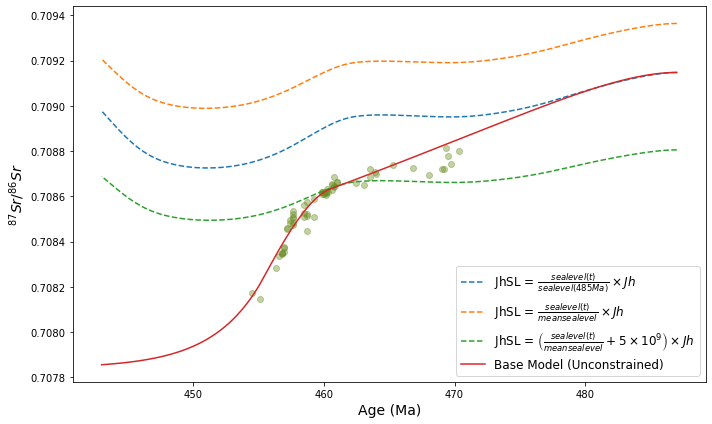

In [48]:
%%time
paramSL = {
    'tmin' : 487,
    'tmax' : 443,
    'nt' : 100000,
    
    'Jriv' : 3e10,
    'Rriv' : 0.7106,
    
    'Jh' : 8e9,
    'Rh' : 0.7037,
    
    'N' : 1.9e17,
    
    'SimplePerturbation' : False,
    'f1' : 1.6,
    'start' : 460,
    'stop' : 455,
    'f2' : 2.5,
    'Jhvec': Jh_sl_min
}

baseSL = run_model(paramSL)
plt.figure(figsize=(10,6))
plt.plot(baseSL['age'], baseSL['Rsw'], ls='--',label=r'JhSL = $\frac{sealevel(t)}{sealevel(485Ma)}\times Jh$')

paramSL2 = paramSL
paramSL2['Jhvec'] = Jh_sl
baseSL2 = run_model(paramSL2)
plt.plot(baseSL2['age'], baseSL2['Rsw'], ls='--',label=r'JhSL = $\frac{sealevel(t)}{meansealevel}\times Jh$')

paramSL2['Jhvec'] = Jh_sl + 4e9
baseSL2 = run_model(paramSL2)
plt.plot(baseSL2['age'], baseSL2['Rsw'], ls='--',label=r'JhSL = $\left(\frac{sealevel(t)}{meansealevel} + 5\times10^9\right) \times Jh$')
plt.plot(base['age'], base['Rsw'], label='Base Model (Unconstrained)')
plt.scatter(SrOrdo['Age20'], SrOrdo['Sr'], c='olivedrab', alpha=0.4)
plt.legend(fontsize=12)

plt.ylabel(r'$^{87}Sr/^{86}Sr$', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.tight_layout()
plt.savefig('../Figure/SensitivityAnalyses/ScalingFactor.pdf')
plt.savefig('../Figure/SensitivityAnalyses/ScalingFactor.png')